# CT偵測

In [1]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras import layers
from tensorflow.keras.models import Model
import numpy as np


In [2]:
# 預先訓練好的模型 -- VGG16, 不含後三層(辨識層)
base_model = VGG16(weights='imagenet', include_top=False)

# 連接自訂層
x = base_model.output
#x = layers.Flatten()(x)
x = layers.GlobalAveragePooling2D()(x)
#x = layers.Dropout(0.2)(x)
x = layers.Dense(256, activation='relu')(x)
#x = layers.Dropout(0.2)(x)
x = layers.Dense(64, activation='relu')(x)
x = layers.Dense(2, activation='sigmoid')(x)

# 設定新模型的 inputs/outputs
model = Model(inputs=base_model.input, outputs=x)

# VGG16 原有的層均不重新訓練
for layer in base_model.layers:
    layer.trainable = False
    
model.compile(optimizer='adam', loss='binary_crossentropy')    

In [3]:
# 讀取 data 目錄下所有圖檔
from os import listdir
from os.path import isfile, join
from os import path

if not path.exists("mask.npy"):
    # 讀取 data/with_mask 目錄下所有圖片檔名
    img_path = './data/CT_COVID/'
    image_files = np.array([join(img_path, f) for f in listdir(img_path) if isfile(join(img_path, f)) and f[-3:] == 'png'])

    # 讀取 data/without_mask 目錄下所有圖片檔名
    img_path = './data/CT_NonCOVID/'
    image_files2 = np.array([join(img_path, f) for f in listdir(img_path) if isfile(join(img_path, f)) and f[-3:] == 'png'])


In [4]:
# 讀取 data 目錄下所有圖檔
if not path.exists("COVID.npy"):
    X = np.array([])
    # 讀取 data/without_mask 目錄下所有圖檔
    for f in image_files2:
        # 載入圖檔，並縮放寬高為 (224, 224) 
        img = image.load_img(f, target_size=(224, 224))
        # 加一維，變成 (1, 224, 224, 3)，最後一維是色彩
        img2 = image.img_to_array(img)
        img2 = np.expand_dims(img2, axis=0)
        if len(X.shape) == 1:
            X = img2
        else:
            # 合併每個圖檔的像素
            X = np.concatenate((X, img2), axis=0)

    # 讀取 data/with_mask 目錄下所有圖檔
    for f in image_files:
        # 載入圖檔，並縮放寬高為 (224, 224) 
        img = image.load_img(f, target_size=(224, 224))
        # 加一維，變成 (1, 224, 224, 3)，最後一維是色彩
        img2 = image.img_to_array(img)
        img2 = np.expand_dims(img2, axis=0)
        if len(X.shape) == 1:
            X = img2
        else:
            X = np.concatenate((X, img2), axis=0)

    X = preprocess_input(X)
    
    np.save('COVID', X)


In [5]:
# 產生 label， with_mask = 1， without_mask = 0
if not path.exists("COVID_y.npy"):
    from tensorflow.keras.utils import to_categorical

    y = np.concatenate((np.zeros(image_files2.shape[0]), np.ones(image_files.shape[0])))
    # one-hot encoding
    y = to_categorical(y, num_classes=2)
    
    np.save('COVID_y', y)

In [6]:
if path.exists("COVID.npy"):
    X = np.load("COVID.npy")
if path.exists("COVID_y.npy"):
    y = np.load("COVID_y.npy")
    

In [7]:
X.shape, y.shape

((544, 224, 224, 3), (544, 2))

In [9]:
model.fit(X, y, epochs=5, validation_split=0.2, verbose=2)

Epoch 1/5
14/14 - 57s - loss: 0.0609 - val_loss: 0.8825 - 57s/epoch - 4s/step
Epoch 2/5
14/14 - 60s - loss: 0.0346 - val_loss: 0.9930 - 60s/epoch - 4s/step
Epoch 3/5
14/14 - 56s - loss: 0.0273 - val_loss: 0.7850 - 56s/epoch - 4s/step
Epoch 4/5
14/14 - 56s - loss: 0.0165 - val_loss: 0.7744 - 56s/epoch - 4s/step
Epoch 5/5
14/14 - 55s - loss: 0.0115 - val_loss: 0.9007 - 55s/epoch - 4s/step


1/1 [==============================] - 0s 127ms/step
COVID機率：97.10


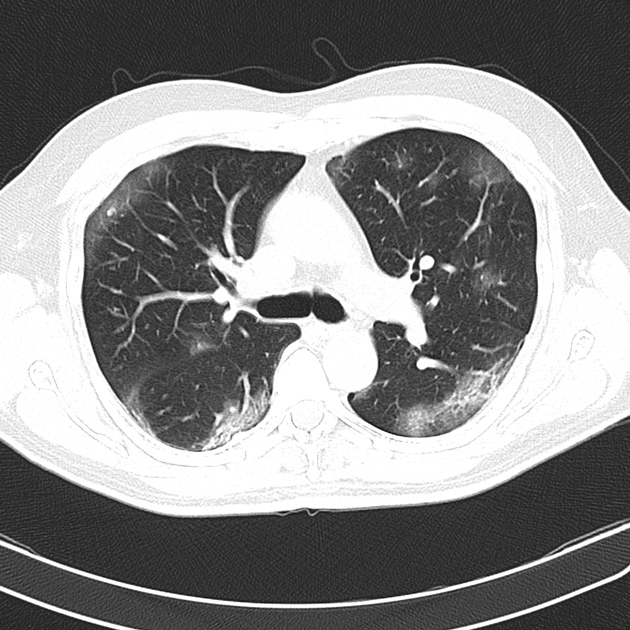

In [13]:
# 任意一張圖片測試
img_path = './COVID.jpeg'
# 載入圖檔，並縮放寬高為 (224, 224) 
img = image.load_img(img_path, target_size=(224, 224))
# 加一維，變成 (1, 224, 224, 3)，最後一維是色彩
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

print(f'COVID機率：{round(model.predict(x)[0][1] * 100, 2):.2f}')

from IPython.display import Image
Image(img_path, width=200)

1/1 [==============================] - 0s 91ms/step
COVID機率：99.45


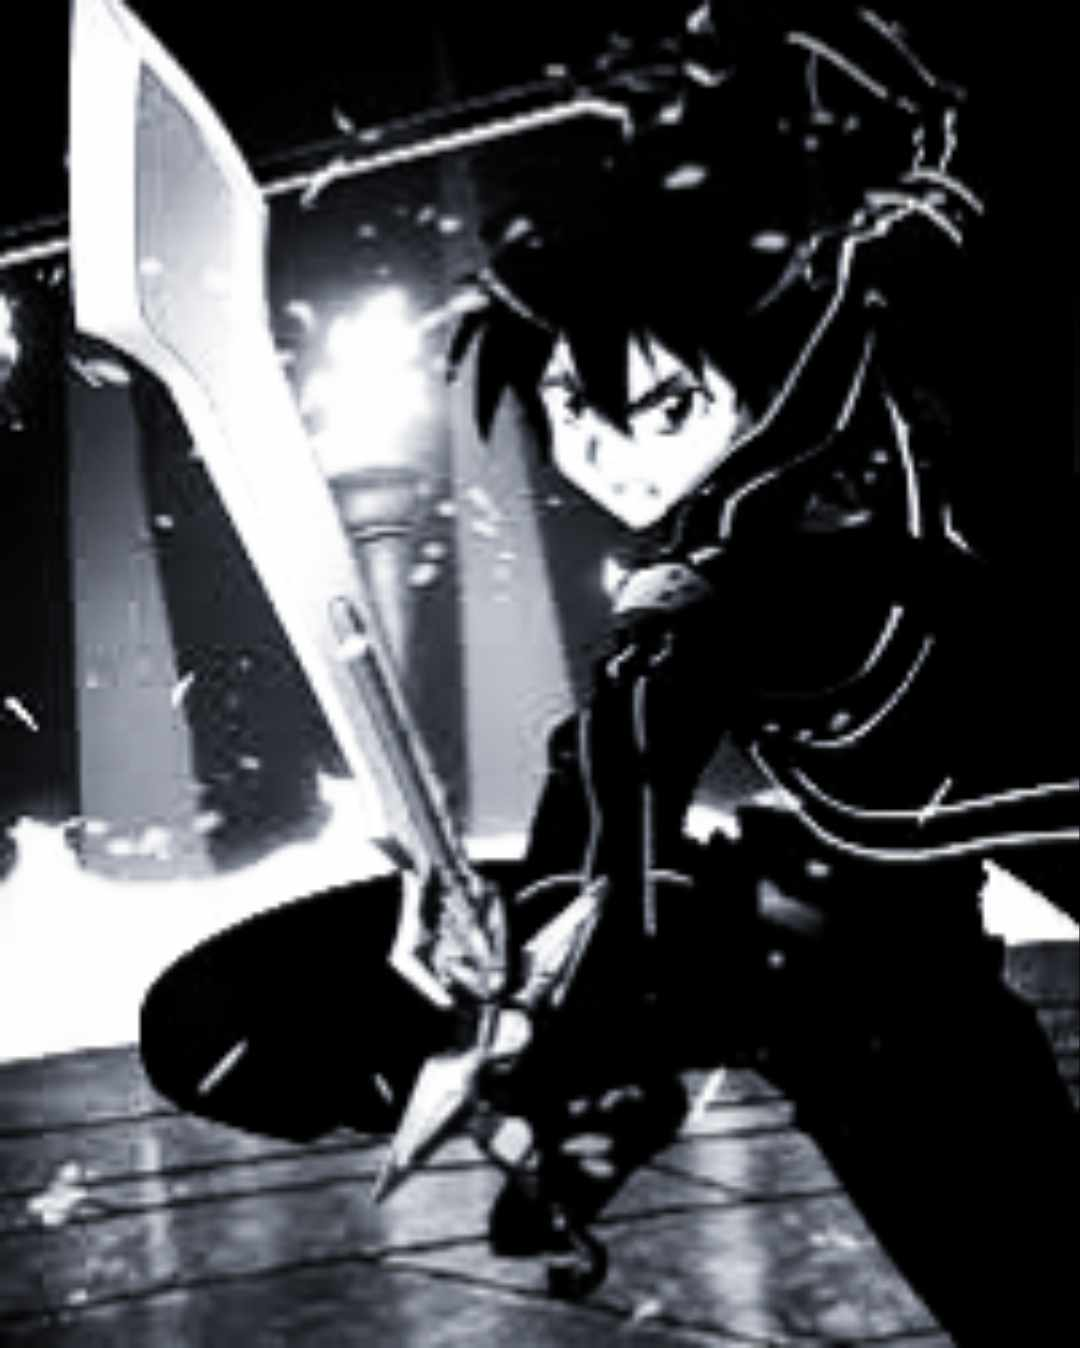

In [19]:
# 任意一張圖片測試
img_path = './SAO2.jpg'
# 載入圖檔，並縮放寬高為 (224, 224) 
img = image.load_img(img_path, target_size=(224, 224))
# 加一維，變成 (1, 224, 224, 3)，最後一維是色彩
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
x = preprocess_input(x)

print(f'COVID機率：{round(model.predict(x)[0][1] * 100, 2):.2f}')

from IPython.display import Image
Image(img_path, width=200)

In [ ]:
model.save('mask_model.h5')

In [15]:
import tensorflow as tf
mnist = tf.keras.datasets.mnist

# 匯入 MNIST 手寫阿拉伯數字 訓練資料
(x_train, y_train),(x_test, y_test) = mnist.load_data()
# 特徵縮放，使用常態化(Normalization)，公式 = (x - min) / (max - min)
# 顏色範圍：0~255，所以，公式簡化為 x / 255
x_train, x_test = x_train / 255.0, x_test / 255.0

# 建立模型
model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(28, 28)),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(10, activation='softmax')
])

# 設定優化器(optimizer)、損失函數(loss)、效能衡量指標(metrics)的類別
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# 模型訓練
model.fit(x_train, y_train, epochs=5)
# 模型評估，打分數
model.evaluate(x_test, y_test)

11490434/11490434 [==============================] - 3s 0us/step
Epoch 1/5
1875/1875 [==============================] - 3s 2ms/step - loss: 0.2925 - accuracy: 0.9154
Epoch 2/5
1875/1875 [==============================] - 3s 2ms/step - loss: 0.1463 - accuracy: 0.9570
Epoch 3/5
1875/1875 [==============================] - 3s 1ms/step - loss: 0.1097 - accuracy: 0.9674
Epoch 4/5
1875/1875 [==============================] - 3s 2ms/step - loss: 0.0896 - accuracy: 0.9725
Epoch 5/5
313/313 [==============================] - 1s 1ms/step - loss: 0.0807 - accuracy: 0.9744


[0.08066830039024353, 0.974399983882904]

In [32]:
# 將非0的數字轉為1，顯示第1張圖片
data = x_train[3].copy()
print(len(list(x_train)))
print(len(x_train[0]))
print(x_train[0])
data[data>0]=1
# 將轉換後二維內容顯示出來，隱約可以看出數字為 5
text_image=[]
for i in range(data.shape[0]):
    text_image.append(''.join(str(data[i])))
text_image

60000
28
[[0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.
  0.      

['[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.\n 0. 0. 0. 0.]',
 '[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.\n 0. 0. 0. 0.]',
 '[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.\n 0. 0. 0. 0.]',
 '[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.\n 0. 0. 0. 0.]',
 '[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.\n 0. 0. 0. 0.]',
 '[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0.\n 0. 0. 0. 0.]',
 '[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 0. 0.\n 0. 0. 0. 0.]',
 '[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 0. 0.\n 0. 0. 0. 0.]',
 '[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 0. 0.\n 0. 0. 0. 0.]',
 '[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 0. 0. 0. 0.\n 0. 0. 0. 0.]',
 '[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 0.\n 0. 